In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [12]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyarrow as pa

from setup.data_wrangle import *
from setup.setup import *
from analysis.analysis import *

sns.set_theme()


In [6]:
# create_cases(AIRBOUNDARY_FOLDER)

In [7]:
cases = retrieve_cases(AIRBOUNDARY_FOLDER)
sc = cases[2]
sc
room_map =  create_room_map(sc.path_to_input)

In [22]:
df_rate = create_zone_rate_df(sc)
df_rate = df_rate.with_columns(time=pl.col("datetimes").dt.to_string("%H:%M"))

df_rate = df_rate.with_columns(heat=pl.when(pl.col("qoi").str.contains("Gain")).then(pl.lit("Gain")).otherwise(pl.lit("Loss")))

df_rate = df_rate.with_columns(type=pl.when(pl.col("qoi").str.contains("Ventilation")).then(pl.lit("Vent")).otherwise(pl.lit("Mixing")))
df_rate.head(1)

fx = lambda name: convert_zone_space_name(room_map, name)
df_rate = df_rate.with_columns(rooms=pl.col("space_names").map_elements(fx, return_dtype=pl.String), )
# to_string("%H:%M")

df_rate.head(2)

case_names,space_names,datetimes,qoi,values,time,heat,type,rooms
str,str,datetime[μs],str,f64,str,str,str,str
"""red_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:00:00,"""AFN Zone Ventilation Sensible …",0.0,"""00:00""","""Gain""","""Vent""","""0-dining"""
"""red_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:15:00,"""AFN Zone Ventilation Sensible …",0.0,"""00:15""","""Gain""","""Vent""","""0-dining"""


Text(0.5, 0.98, 'red_b1')

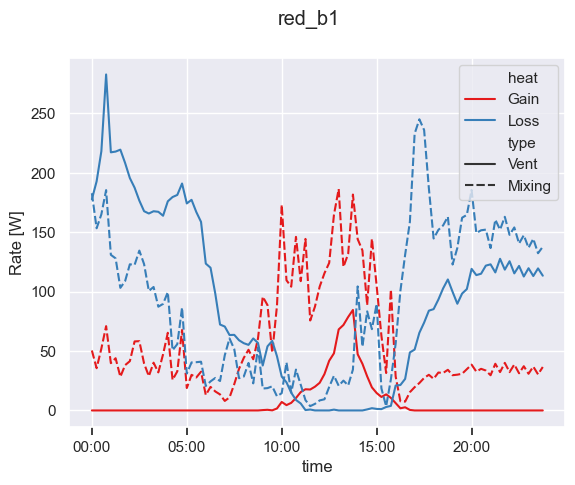

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1,)
sns.lineplot(data=df_rate, y="values", x="time", hue="heat", ax=ax, errorbar=None, style="type", dashes=True, palette="Set1")

ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.set_ylabel("Rate [W]")
fig.suptitle(sc.case_name)


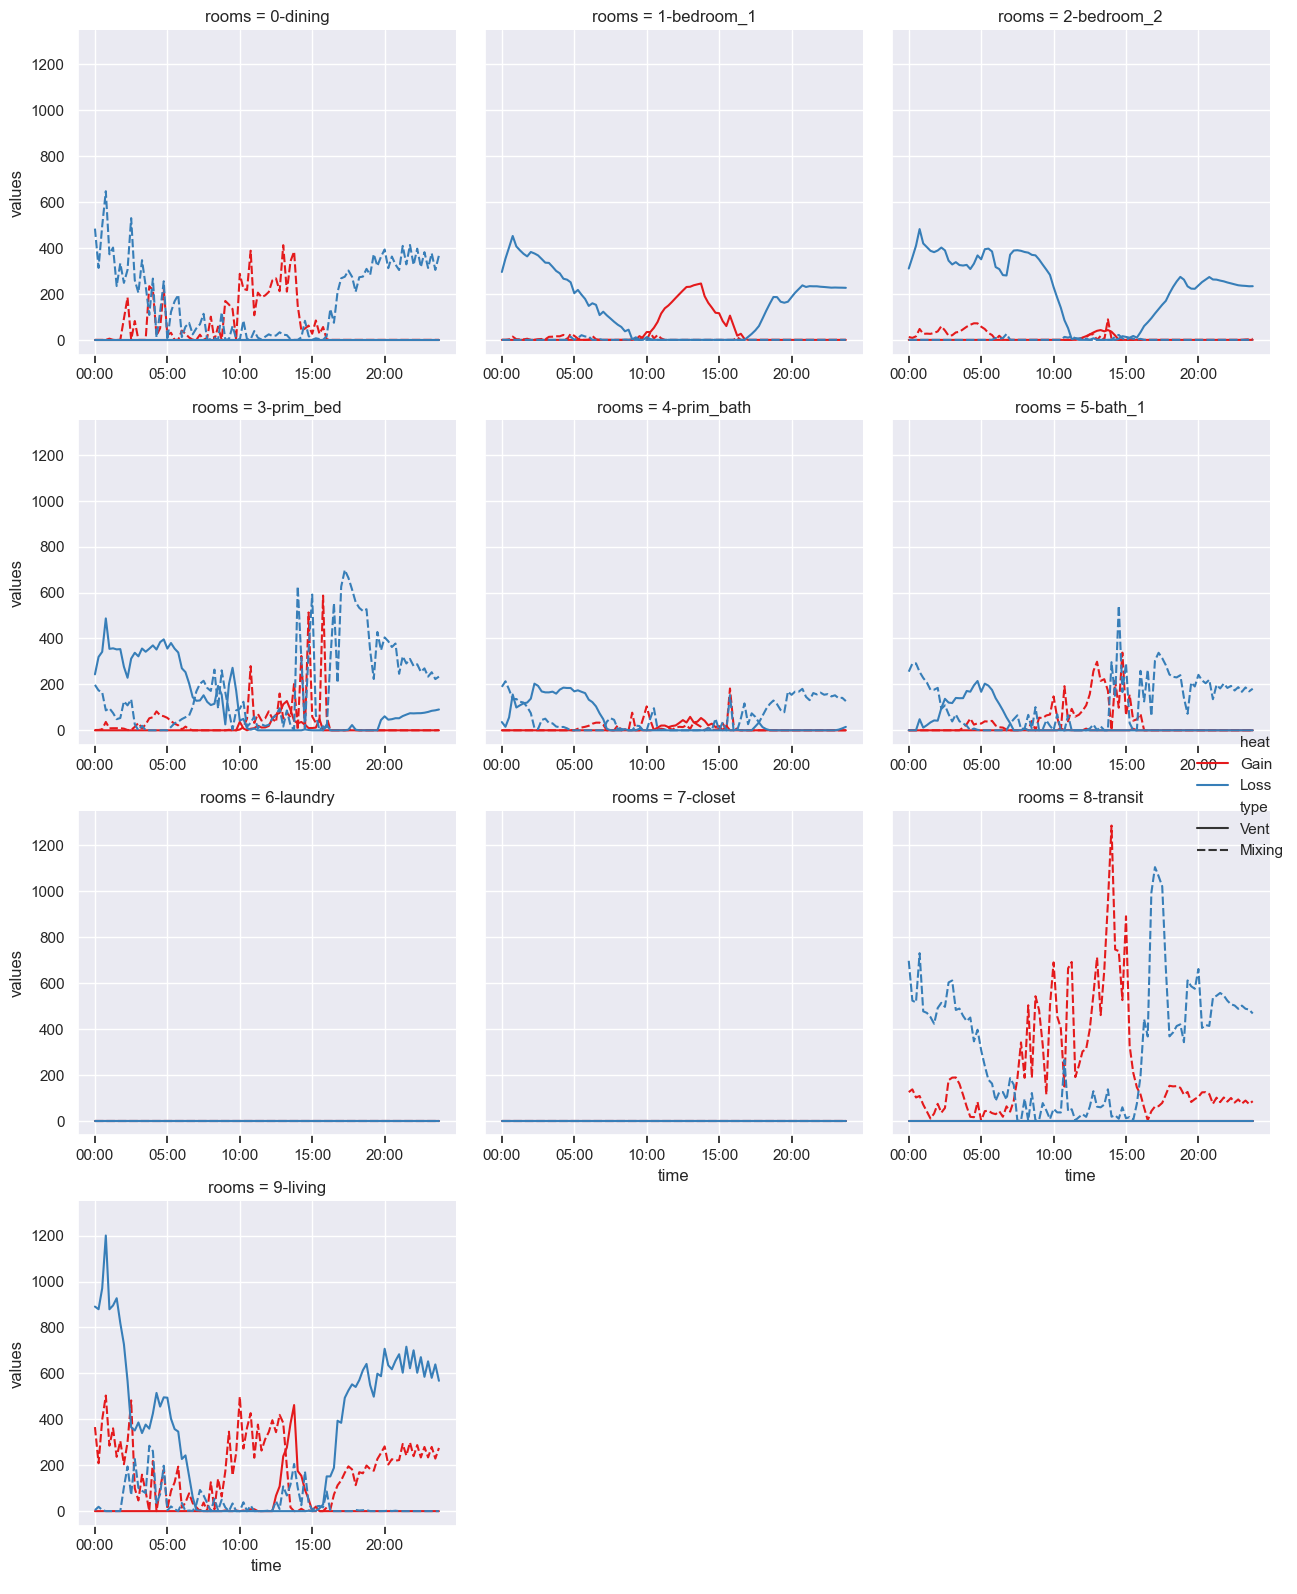

In [44]:

g = sns.relplot(df_rate,x="time", y="values",  col="rooms", hue="heat", col_wrap=3, palette="Set1", kind="line", errorbar=None, style="type", dashes=True, height=4 )
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")

In [43]:
# site data.. 
df_site = create_site_df(sc)
df_site = df_site.with_columns(time=pl.col("datetimes").dt.to_string("%H:%M"))
df_site.head(2)

case_names,space_names,datetimes,qoi,values,time
str,str,datetime[μs],str,f64,str
"""red_b1""","""Environment""",2017-07-01 00:00:00,"""Site Outdoor Air Drybulb Tempe…",18.65,"""00:00"""
"""red_b1""","""Environment""",2017-07-01 00:15:00,"""Site Outdoor Air Drybulb Tempe…",17.6,"""00:15"""


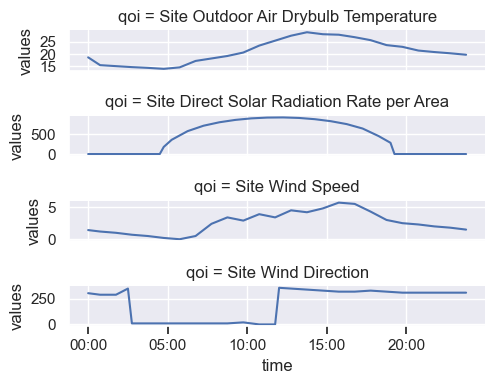

In [66]:
g = sns.FacetGrid(df_site, row="qoi",sharey=False, sharex=True, height=1, aspect=5,)
g.map(sns.lineplot, "time", "values",)

for ax in [g.axes.flat[-1]]:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())

g.add_legend()